## Introducción a pre-trained models, transfer learning and fine tunning

En este notebook encontrarás material introductorio para entender los conceptos de modelos preentrenados, transferencia de aprendizaje y ajuste fino. Y cómo estos, empleados de forman correcta, pueden aumentar el rendimiento de tus modelos.

**Modelos preentrenados**

En esta sección, utilizaremos el modelo pre-entrenado [VGG16](https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG16), el cual es una red convolucional que es usada para reconocimiento de imágenes. Este modelo fue entrenado con ImageNet, por lo cual es un modelo bastante robusto.

#### Objetivo:
- El objetivo será cargar dicho modelo pre-entrenado y utilizarlo sobre el dataset [MNIST](https://www.tensorflow.org/datasets/catalog/mnist), el cual contiene 70.000 imagenes de digitos escritos a mano. Así, poder clasificar dichos números con nuestro modelo entrenado previamente.

In [19]:
# Importamos las librerias a utilizar
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import VGG16
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Cargamos el dataset MNIST
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
print("Train shape: ", train_images.shape)
print("Test shape: ", test_images.shape)

Train shape:  (60000, 28, 28)
Test shape:  (10000, 28, 28)


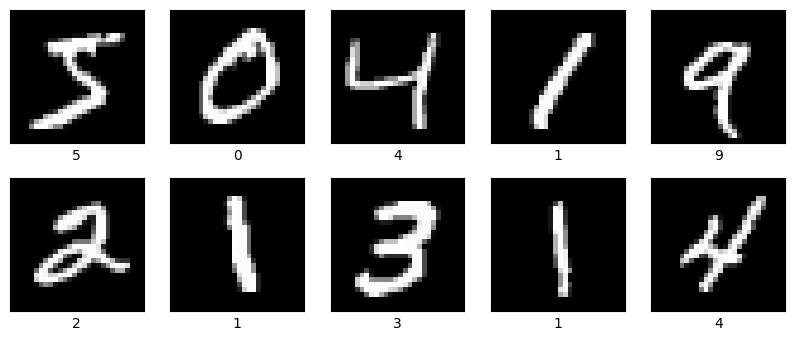

In [20]:
# dibujamos ciertos ejemplos de entrenamiento
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_images[i], cmap=plt.cm.gray)
    plt.xlabel(train_labels[i])
plt.show()

In [21]:
# Redimensionamos las imagenes a 32x32 (el minimo tamaño que soporta vgg16)
train_images = tf.image.grayscale_to_rgb(tf.expand_dims(train_images, axis=-1))
test_images = tf.image.grayscale_to_rgb(tf.expand_dims(test_images, axis=-1))
# Agregamos 3 canales de color (RGB) debido a que la red tambien lo necesita
train_images = tf.image.resize(train_images, [32, 32])
test_images = tf.image.resize(test_images, [32, 32])
# Normalizamos las imagenes entre [0, 1] para que el aprendizaje sea mas suave
train_images = train_images / 255.0
test_images = test_images / 255.0
print("Train shape: ", train_images.shape)
print("Test shape: ", test_images.shape)

Train shape:  (60000, 32, 32, 3)
Test shape:  (10000, 32, 32, 3)


In [22]:
# Convertimos las etiquetas a formato one-hot encoding
train_labels_ohc = to_categorical(train_labels, 10)
test_labels_ohc = to_categorical(test_labels, 10)
print(train_labels_ohc[:,1])

[0. 0. 0. ... 0. 0. 0.]


In [23]:
# Cargamos el modelo VGG16 preentrenado, excluyendo las capas superiores (top=False)
# Recuerde que las capas superiores son las que definen el tipo de problema a solucionar
# Como nuestro problema es de 10 categorias (10 digitos), agregaremos nuestras propias capas superiores
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
vgg16_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Ahora congelamos los pesos del modelo, pues solo queremos agrega una nueva capa
# con 10 neuronas, donde cada una representará el digito que queremos predecir
vgg16_base.trainable = False
model = models.Sequential([
    vgg16_base,
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')  # 10 clases de salida
])

In [ ]:
# Compilamos y entrenamos los pesos de nuestra última capa

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_images, train_labels_ohc, epochs=5,
                    batch_size=64, validation_data=(test_images, test_labels_ohc))

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.5696 - loss: 1.3550 - val_accuracy: 0.8695 - val_loss: 0.5477
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.8066 - loss: 0.6340 - val_accuracy: 0.9001 - val_loss: 0.4104
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.8285 - loss: 0.5435 - val_accuracy: 0.9134 - val_loss: 0.3540
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.8417 - loss: 0.5014 - val_accuracy: 0.9167 - val_loss: 0.3250
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.8434 - loss: 0.4833 - val_accuracy: 0.9214 - val_loss: 0.3004


In [ ]:
# Medimos la precisión del modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_images, test_labels_ohc)

print(f"Precisión en el conjunto de prueba: {test_acc}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9128 - loss: 0.3215
Precisión en el conjunto de prueba: 0.9214000105857849


In [18]:
# Mostramos el modelo
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 1, 1, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,730,080 (56.19 MB)

 Trainable params: 14,719,818 (56.15 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,262 (40.09 KB)

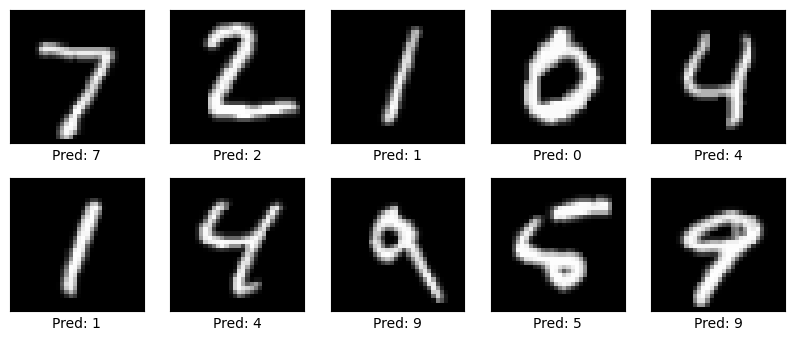

In [ ]:
# Dibujamos ciertas imágenes con sus predicciones
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_images[i], cmap=plt.cm.gray)
    pred = np.argmax(model.predict(np.expand_dims(test_images[i], axis=0), verbose=False))
    plt.xlabel(f"Pred: {pred}")
plt.show()

### Observaciones:

*   Note que al cargar un modelo pre-entrenado, logramos tener unos pesos que ya saben encontrar ciertos tipos de características dentro de las imágenes. Es por ello que cuando entrenamos nuestra capa superior (10 neuronas), solo hacen falta 5 épocas para alcanzar un accuracy del 92.14% en el conjunto de prueba.
* Cabe resaltar que utilizamos un modelo pre-entrenado y agregamos una capa superior para adaptarlo a nuestro problema. Esto se podría considerar *transfer learning* tambien.


**Modelos preentrenados**

Para dejar mas claro el concepto de *transfer learning* lo que haremos es coger el mismo modelo definido anteriormente, solo que esta vez si entrenaremos los pesos del modelo pre-entrenado, para así alcanzar un mejor rendimiento.

In [14]:
# Definimos el modelo, especificando que queremos entrenar el modelo VGG16
vgg16_base.trainable = True
model_2 = models.Sequential([
    vgg16_base,
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')  # 10 clases de salida
])

In [15]:
# Compilamos y entrenamos los pesos de nuestra última capa

model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model_2.fit(train_images, train_labels_ohc, epochs=5,
                    batch_size=64, validation_data=(test_images, test_labels_ohc))

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 59s 51ms/step - accuracy: 0.1089 - loss: 2.3420 - val_accuracy: 0.1135 - val_loss: 2.3011
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 68s 43ms/step - accuracy: 0.1129 - loss: 2.3012 - val_accuracy: 0.1135 - val_loss: 2.3010
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.1142 - loss: 2.3009 - val_accuracy: 0.1135 - val_loss: 2.3010
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 40s 43ms/step - accuracy: 0.1122 - loss: 2.3015 - val_accuracy: 0.1135 - val_loss: 2.3010
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 46s 48ms/step - accuracy: 0.1114 - loss: 2.3013 - val_accuracy: 0.1135 - val_loss: 2.3010


In [16]:
# Medimos la precisión del modelo 2 en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_images, test_labels_ohc)

print(f"Precisión en el conjunto de prueba: {test_acc}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0941 - loss: 2.3274
Precisión en el conjunto de prueba: 0.09740000218153


In [17]:
# Imprimamos la estructura del modelo 2
model_2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 1, 1, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,159,456 (168.45 MB)

 Trainable params: 14,719,818 (56.15 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 29,439,638 (112.30 MB)

### Observaciones:

*   Antes de hablar del mal rendimiento del modelo (un 9.7% de accuracy en el conjunto de prueba). Hay que hablar de que ahora demoró mas entrenandose. Esto se debe a que ahora, se ajustaron todos los parámeros posibles, no como en el modelo anterior que solo ajustamos los parámetros de la capa superior.

* Una de las razones por las cuales se obtuvo un *accuracy* muy bajo, es debido a que empezamos a ajustar el modelo pre-entrenado, pero pasamos de tener 512 neuronas como salida del modelo pre-entrenado, a solo tener 10. Entonces ese error se propagó y ajsuto erróneamente los pesos ya entrenados. Lo cual llevó a que el modelo no mejorara.

* Para mitigar este error, utilizaremos *fine tunning* ajustando mas la capa superior. Así podremos tener un mejor rendimiento de nuestro modelo de *transfer learning*

**Fien tunning**

- Para el ajuste fino, lo que haremos es lo siguiente:
  - Congelaremos las primeras capas del modelo pre-entrenado
  - Agregaremos unas capas superiores al modelo.
  - Etrenaremos el modelo así.
  - Después, descongelaremos capas superiores del modelo pre-entrenado y hacemos ese ajuste fino (entrenamos) para aumentar el acierto del modelo.

In [33]:
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

for layer in vgg16_base.layers[:15]:  # Congelar las primeras 15 capas
    layer.trainable = False

# Agregamos mas neuronas después de nuestro modelo pre-entrenado, para hacer un ajuste mas fino
model_3 = models.Sequential([
    vgg16_base,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),  # Incrementamos el número de unidades para mayor capacidad de representación
    layers.Dropout(0.5),                   # Aumentamos el Dropout para evitar el sobreajuste
    layers.Dense(10, activation='softmax') # Capa final con 10 clases
])

In [34]:
# compilamos el modelo y definimos una parada temprana para mitigar el sobreajuste
model_3.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [35]:
# Entrenamos nuestro modelo
history = model_3.fit(train_images, train_labels_ohc, batch_size=64,
                      epochs=20,
                      validation_data=(test_images, test_labels_ohc),
                      callbacks=[early_stopping])

Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - accuracy: 0.8984 - loss: 0.3147 - val_accuracy: 0.9872 - val_loss: 0.0399
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.9848 - loss: 0.0511 - val_accuracy: 0.9911 - val_loss: 0.0283
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.9905 - loss: 0.0321 - val_accuracy: 0.9862 - val_loss: 0.0458
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.9906 - loss: 0.0334 - val_accuracy: 0.9915 - val_loss: 0.0269
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.9921 - loss: 0.0245 - val_accuracy: 0.9894 - val_loss: 0.0342
Epoch 6/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.9933 - loss: 0.0240 - val_accuracy: 0.9911 - val_loss: 0.0327
Epoch 7/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.9937 - loss: 0.0196 - val_accuracy: 0.9920 - val_loss: 0.0261
Epoch 8/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.9941 - loss: 0.0184 - 

In [37]:
# Evaluamos el accuracy del modelo en los datos de prueba
test_loss, test_acc = model_3.evaluate(test_images, test_labels_ohc)
print(f"Precisión después del fine-tuning avanzado: {test_acc}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9917 - loss: 0.0323
Precisión después del fine-tuning avanzado: 0.9929999709129333


In [38]:
# Ahora descongelamos ciertos pesos de las capas del modelo pre-entrenado y entrenamos de nuevo nuestro modelo
for layer in vgg16_base.layers[15:]:
    layer.trainable = True

# Compilamos nuevamente nuestro modelo con un learning rate mas bajo para hacer el fine tunning
model_3.compile(optimizer=optimizers.RMSprop(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [39]:
# Entrenamos nuestro modelo de ajuste fino
history = model_3.fit(train_images, train_labels_ohc, batch_size=64,
                      epochs=10,
                      validation_data=(test_images, test_labels_ohc),
                      callbacks=[early_stopping])

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.9977 - loss: 0.0070 - val_accuracy: 0.9940 - val_loss: 0.0215
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.9990 - loss: 0.0037 - val_accuracy: 0.9940 - val_loss: 0.0224
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.9991 - loss: 0.0038 - val_accuracy: 0.9940 - val_loss: 0.0239
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.9992 - loss: 0.0030 - val_accuracy: 0.9940 - val_loss: 0.0243
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.9993 - loss: 0.0024 - val_accuracy: 0.9939 - val_loss: 0.0244
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.9992 - loss: 0.0036 - val_accuracy: 0.9937 - val_loss: 0.0266


In [41]:
# Evaluamos el accuracy de nuestro modelo con fine tunning
test_loss, test_acc = model_3.evaluate(test_images, test_labels_ohc)
print(f"Precisión final después del fine-tuning avanzado: {test_acc}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9923 - loss: 0.0299
Precisión final después del fine-tuning avanzado: 0.9940000176429749


## **Conclusiones**

- Note que al agregarle al modelo mas capas superiores, logramos mitigar el problema que presentamos en nuestro modelo 2, logrando un *accuracy* del 99.30% en nuestro datos de prueba.
- Al aplicar el *fine tunning* en nuestro tercer modelo. Este logró mejorar un 1% en los datos de prueba, presentando un *accuracy* del 99.4%. Si bien, en otros conjunto de datos el incrimento podría ser mayor
- Como conlusión, cuando hagamos uso de modelo pre-entrenados. Tenemos que hacer uso de todas las herramientas que disponemos, como lo son el *transfer learning* y el *fine tunning*, una caracteristica muy importante que siempre hay que aplicar.